In [2]:
!pip install nltk
!pip install wordcloud

In [3]:
import nltk
nltk.download('punkt') # For tokenizing text
nltk.download('stopwords') # For removing stop words
nltk.download('wordnet') # For lemmatization

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\G.SUBRAMANIAN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\G.SUBRAMANIAN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\G.SUBRAMANIAN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
import pandas as pd

# ---- 1. Load the datasets ----
try:
    fake_df = pd.read_csv('fake.csv')
    true_df = pd.read_csv('true.csv')
    print("✅ Successfully loaded fake.csv and true.csv")

except FileNotFoundError:
    print("❌ Error: Could not find fake.csv or true.csv. Please ensure they are in the same folder.")
    # Stop execution if files are not found
    exit()


# ---- 2. Add 'label' column to each dataframe ----
# This is our target variable for classification.
# 0 = Fake News
# 1 = Real News
fake_df['label'] = 0
true_df['label'] = 1


# ---- 3. Combine the two dataframes ----
# We'll append the true news dataframe to the fake news one.
# We set ignore_index=True to reset the index of the combined dataframe.
df = pd.concat([fake_df, true_df], ignore_index=True)


# ---- 4. Shuffle the dataframe ----
# It's crucial to shuffle the data. Otherwise, our model would learn on all the fake news first,
# then all the real news, which can bias the training process.
# `frac=1` means we want to shuffle 100% of the rows.
# `random_state=42` ensures we get the same shuffle every time we run the code.
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


# ---- 5. Display information about our final dataset ----
print("\n--- Combined and Shuffled Dataset ---")
print(f"Total articles: {len(df)}")
print(f"Columns: {df.columns.tolist()}")

print("\n--- First 5 rows of the combined data ---")
print(df.head())

print("\n--- Value counts for our labels ---")
# This should show a roughly even split between 0s and 1s.
print(df['label'].value_counts())


✅ Successfully loaded fake.csv and true.csv

--- Combined and Shuffled Dataset ---
Total articles: 44898
Columns: ['title', 'text', 'subject', 'date', 'label']

--- First 5 rows of the combined data ---
                                               title  \
0  Ben Stein Calls Out 9th Circuit Court: Committ...   
1  Trump drops Steve Bannon from National Securit...   
2  Puerto Rico expects U.S. to lift Jones Act shi...   
3   OOPS: Trump Just Accidentally Confirmed He Le...   
4  Donald Trump heads for Scotland to reopen a go...   

                                                text       subject  \
0  21st Century Wire says Ben Stein, reputable pr...       US_News   
1  WASHINGTON (Reuters) - U.S. President Donald T...  politicsNews   
2  (Reuters) - Puerto Rico Governor Ricardo Rosse...  politicsNews   
3  On Monday, Donald Trump once again embarrassed...          News   
4  GLASGOW, Scotland (Reuters) - Most U.S. presid...  politicsNews   

                  date  label  
0    Fe

In [5]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string

# ---- 1. Combine title and text ----
# We'll create a new column 'full_text' to have all text content in one place.
# We also handle any potential missing data by filling it with an empty string.
df['full_text'] = df['title'].fillna('') + ' ' + df['text'].fillna('')


# ---- 2. Define the preprocessing function ----
# Initialize the tools we need from NLTK
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # 1. Convert to lowercase
    text = text.lower()
    
    # 2. Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # 3. Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # 4. Remove numbers (optional, but good for this task)
    text = re.sub(r'\d+', '', text)
    
    # 5. Tokenize the text (split into a list of words)
    tokens = nltk.word_tokenize(text)
    
    # 6. Remove stopwords and lemmatize
    cleaned_tokens = []
    for word in tokens:
        # Keep the word if it's not a stopword and is alphabetic
        if word not in stop_words and word.isalpha():
            cleaned_tokens.append(lemmatizer.lemmatize(word))
            
    # 7. Join the cleaned tokens back into a single string
    return " ".join(cleaned_tokens)


# ---- 3. Apply the function to our 'full_text' column ----
# This is the most time-consuming step. It will iterate through all ~45,000 articles.
# This might take a few minutes to complete.
print("Starting text preprocessing on all articles...")
df['cleaned_text'] = df['full_text'].apply(preprocess_text)
print("✅ Text preprocessing complete!")


# ---- 4. Display an example to see the result ----
print("\n--- Preprocessing Example ---")

# Select a random row to see the before and after
example_row = df.sample(1, random_state=101)

print("\nOriginal Text:")
# We use .values[0] to extract the string from the pandas Series
print(example_row['full_text'].values[0][:500] + "...") # Print first 500 chars

print("\n--------------------------")

print("\nCleaned & Lemmatized Text:")
print(example_row['cleaned_text'].values[0][:500] + "...")



Starting text preprocessing on all articles...
✅ Text preprocessing complete!

--- Preprocessing Example ---

Original Text:
EU to race Britain for Australia, NZ trade deals STRASBOURG (Reuters) - The European Union wants to launch and conclude free trade negotiations with Australia and New Zealand in the next two years, European Commission President Jean-Claude Juncker said on Wednesday, opening up a potential race with Britain. If Juncker s timeframe is achieved, the EU could nip in ahead of the UK, which is also courting both countries but cannot negotiate independent trade deals until it leaves the EU in March 201...

--------------------------

Cleaned & Lemmatized Text:
eu race britain australia nz trade deal strasbourg reuters european union want launch conclude free trade negotiation australia new zealand next two year european commission president jeanclaude juncker said wednesday opening potential race britain juncker timeframe achieved eu could nip ahead uk also courting cou

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

# ---- 1. Define Features (X) and Target (y) ----
# We use the cleaned text as our feature and the label as our target.
X = df['cleaned_text']
y = df['label']


# ---- 2. Split Data into Training and Testing Sets ----
# We will use 80% of the data for training and 20% for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)} articles")
print(f"Testing set size: {len(X_test)} articles")


# ---- 3. Initialize and Apply TF-IDF Vectorizer ----
# We'll limit the vocabulary to the top 10,000 words (unigrams and bigrams).
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

# Fit the vectorizer and transform the TRAINING data.
# `fit_transform` learns the vocabulary and creates the TF-IDF matrix in one step.
print("\nFitting vectorizer and transforming training data...")
X_train_tfidf = vectorizer.fit_transform(X_train)

# ONLY transform the TESTING data.
# This uses the vocabulary learned from the training data to create the matrix for the test set.
print("Transforming testing data...")
X_test_tfidf = vectorizer.transform(X_test)


# ---- 4. Check the results ----
print(f"\nShape of TF-IDF training matrix: {X_train_tfidf.shape}")
print(f"Shape of TF-IDF testing matrix: {X_test_tfidf.shape}")


# ---- 5. Save the fitted vectorizer ----
# This is important so we can use the exact same vocabulary for any new data in the future.
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

print("\n✅ TF-IDF vectorizer saved as 'tfidf_vectorizer.pkl'")



Training set size: 35918 articles
Testing set size: 8980 articles

Fitting vectorizer and transforming training data...
Transforming testing data...

Shape of TF-IDF training matrix: (35918, 10000)
Shape of TF-IDF testing matrix: (8980, 10000)

✅ TF-IDF vectorizer saved as 'tfidf_vectorizer.pkl'


Training the Logistic Regression model...
✅ Model training complete!

Making predictions on the test set...

Model Accuracy: 98.76%
Model F1-Score: 0.9871

--- Classification Report ---
              precision    recall  f1-score   support

        Fake       0.99      0.98      0.99      4710
        Real       0.98      0.99      0.99      4270

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980


--- Confusion Matrix ---


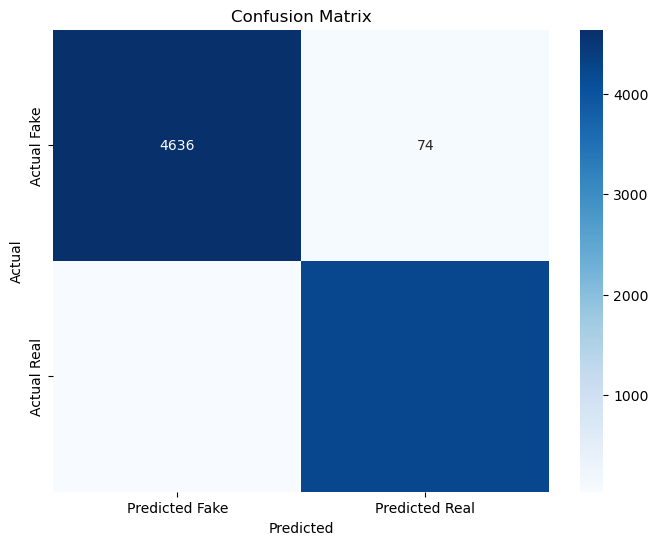


✅ Trained model saved as 'fake_news_model.pkl'


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# ---- 1. Initialize and Train the Model ----
# We'll use Logistic Regression. max_iter is increased to ensure the model has enough iterations to converge.
model = LogisticRegression(max_iter=1000, random_state=42)

print("Training the Logistic Regression model...")
# Train the model using our TF-IDF training data and the corresponding labels.
model.fit(X_train_tfidf, y_train)
print("✅ Model training complete!")


# ---- 2. Make Predictions on the Test Data ----
print("\nMaking predictions on the test set...")
# Use the trained model to predict the labels for the unseen test data.
y_pred = model.predict(X_test_tfidf)


# ---- 3. Evaluate the Model's Performance ----
# Compare the model's predictions (y_pred) with the actual true labels (y_test).

# Accuracy: The percentage of predictions that were correct.
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy * 100:.2f}%")

# F1-Score: A balanced measure of precision and recall, useful for imbalanced datasets.
f1 = f1_score(y_test, y_pred)
print(f"Model F1-Score: {f1:.4f}")

# Detailed Classification Report
print("\n--- Classification Report ---")
# This shows precision, recall, and f1-score for each class (0 = Fake, 1 = Real).
print(classification_report(y_test, y_pred, target_names=['Fake', 'Real']))


# ---- 4. Visualize the Confusion Matrix ----
# A confusion matrix shows how many predictions were right and wrong for each class.
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Fake', 'Predicted Real'],
            yticklabels=['Actual Fake', 'Actual Real'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


# ---- 5. Save the Trained Model ----
# We save the model so we can use it later without retraining.
joblib.dump(model, 'fake_news_model.pkl')
print("\n✅ Trained model saved as 'fake_news_model.pkl'")



--- Word Clouds for Fake vs. Real News ---


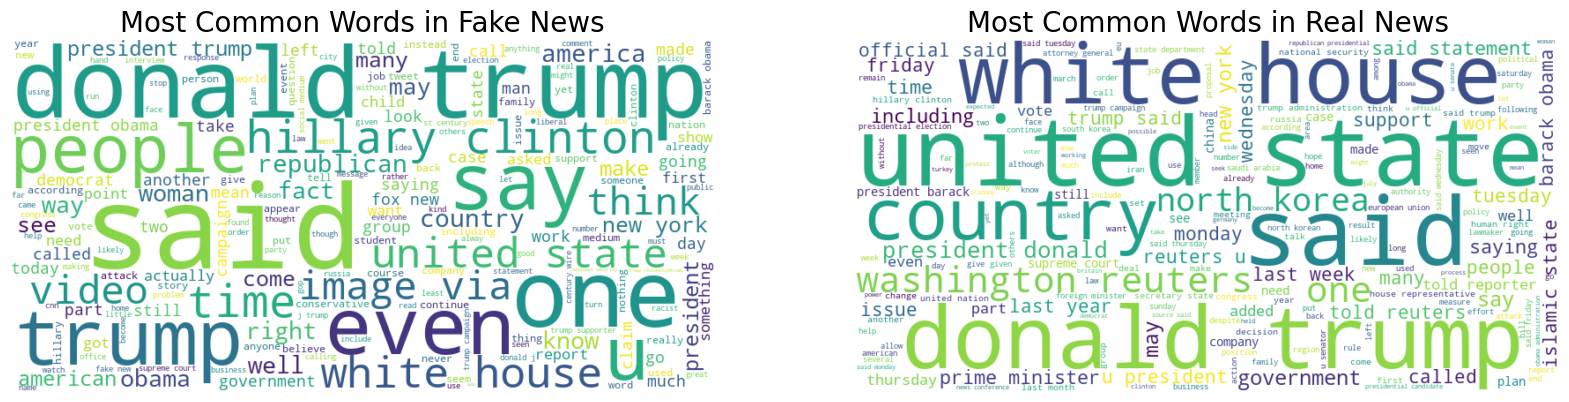

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# ---- 1. Separate the text for fake and real news ----
# Create a single string containing all the text from fake news articles
fake_text = " ".join(df[df['label'] == 0]['cleaned_text'])

# Create a single string for all real news articles
real_text = " ".join(df[df['label'] == 1]['cleaned_text'])

# ---- 2. Create the WordCloud objects ----
# We can customize the appearance (width, height, background color).
fake_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(fake_text)
real_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(real_text)


# ---- 3. Plot the word clouds side-by-side ----
print("\n--- Word Clouds for Fake vs. Real News ---")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot for Fake News
ax1.imshow(fake_wordcloud, interpolation='bilinear')
ax1.set_title('Most Common Words in Fake News', fontsize=20)
ax1.axis('off') # Hide the axes

# Plot for Real News
ax2.imshow(real_wordcloud, interpolation='bilinear')
ax2.set_title('Most Common Words in Real News', fontsize=20)
ax2.axis('off') # Hide the axes

plt.show()

